# Combat Dataset vs Phantom Simulator

Loads `resources/datasets/combat.pkl.xz`, runs each sample through `phantom/micro/simulator.py`
(via `NumpyLanchesterSimulator`), and compares prediction quality against simple baselines.

In [1]:
from __future__ import annotations

import lzma
import pickle
import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

ROOT = Path.cwd()
if not (ROOT / "phantom").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from phantom.micro.simulator import ModelCombatSetup, NumpyLanchesterSimulator, SimulationUnit

DATASET_PATH = ROOT / "resources/datasets/combat.pkl.xz"
MAX_SAMPLES: int | None = None  # set e.g. 2000 for a faster pass
SEED = 7

rng = np.random.default_rng(SEED)
print(f"Dataset: {DATASET_PATH}")

Dataset: C:\Users\volke\PycharmProjects\phantom-sc2\resources\datasets\combat.pkl.xz


In [2]:
with lzma.open(DATASET_PATH, "rb") as f:
    raw_data = pickle.load(f)

indices = np.arange(len(raw_data))
if MAX_SAMPLES is not None and MAX_SAMPLES < len(indices):
    indices = rng.choice(indices, size=MAX_SAMPLES, replace=False)

data = [raw_data[i] for i in indices]
print(f"Loaded {len(data):,} samples (from {len(raw_data):,} total)")
print("Example keys:", sorted(data[0].keys()))
print("Serialized unit keys:", sorted(data[0]["units"][0].keys()))

Loaded 10,000 samples (from 10,000 total)
Example keys: ['attacking', 'result', 'units']
Serialized unit keys: ['air_dps', 'air_range', 'ground_dps', 'ground_range', 'health', 'is_enemy', 'is_flying', 'position', 'radius', 'real_speed', 'shield', 'tag']


In [3]:
@dataclass
class NotebookParameters:
    time_distribution_lambda: float = 1.0
    lancester_dimension: float = 1.5
    enemy_range_bonus: float = 1.0


def to_simulation_unit(u: dict) -> SimulationUnit:
    return SimulationUnit(
        tag=int(u["tag"]),
        is_enemy=bool(u["is_enemy"]),
        is_flying=bool(u["is_flying"]),
        health=float(u["health"]),
        shield=float(u["shield"]),
        ground_dps=float(u["ground_dps"]),
        air_dps=float(u["air_dps"]),
        ground_range=float(u["ground_range"]),
        air_range=float(u["air_range"]),
        radius=float(u["radius"]),
        real_speed=float(u["real_speed"]),
        position=(float(u["position"][0]), float(u["position"][1])),
    )


def to_model_setup(sample: dict) -> ModelCombatSetup:
    units1: list[SimulationUnit] = []
    units2: list[SimulationUnit] = []
    for unit_dict in sample["units"]:
        unit = to_simulation_unit(unit_dict)
        if unit.is_enemy:
            units2.append(unit)
        else:
            units1.append(unit)
    return ModelCombatSetup(
        units1=units1,
        units2=units2,
        attacking=set(sample["attacking"]),
    )


def sum_hp(units: list[SimulationUnit]) -> float:
    return float(sum(u.health + u.shield for u in units))


def sum_dps(units: list[SimulationUnit]) -> float:
    return float(sum(max(u.ground_dps, u.air_dps) for u in units))


sim = NumpyLanchesterSimulator(NotebookParameters(), num_steps=10)

In [4]:
rows = []
for sample in data:
    setup = to_model_setup(sample)
    if not setup.units1 or not setup.units2:
        continue

    pred = sim.simulate(setup).outcome_global
    hp1 = sum_hp(setup.units1)
    hp2 = sum_hp(setup.units2)
    dps1 = sum_dps(setup.units1)
    dps2 = sum_dps(setup.units2)

    rows.append({
        "true_raw": float(sample["result"]),
        "pred_sim": float(pred),
        "hp_ratio": (hp1 - hp2) / max(1e-9, hp1 + hp2),
        "dps_ratio": (dps1 - dps2) / max(1e-9, dps1 + dps2),
        "n1": len(setup.units1),
        "n2": len(setup.units2),
        "hp1": hp1,
        "hp2": hp2,
    })

print(f"Evaluated {len(rows):,} valid samples")
rows[:2]

Evaluated 10,000 valid samples


[{'true_raw': 379.5,
  'pred_sim': 0.5546535303413244,
  'hp_ratio': 0.10320284697508897,
  'dps_ratio': 0.09430942028328247,
  'n1': 6,
  'n2': 6,
  'hp1': 775.0,
  'hp2': 630.0},
 {'true_raw': 480.34197998046875,
  'pred_sim': -0.26411660040678425,
  'hp_ratio': -0.004543577034283354,
  'dps_ratio': -0.06127535787193062,
  'n1': 22,
  'n2': 22,
  'hp1': 2410.0,
  'hp2': 2432.0}]

In [5]:
true_raw = np.array([r["true_raw"] for r in rows], dtype=float)
pred_sim = np.array([r["pred_sim"] for r in rows], dtype=float)
hp_ratio = np.array([r["hp_ratio"] for r in rows], dtype=float)
dps_ratio = np.array([r["dps_ratio"] for r in rows], dtype=float)

scale = np.quantile(np.abs(true_raw), 0.95)
true_norm = np.tanh(true_raw / scale)

def sign_no_zero(x: np.ndarray) -> np.ndarray:
    y = np.sign(x)
    y[y == 0] = 1
    return y

y_sign = sign_no_zero(true_raw)

def metrics_for(name: str, pred: np.ndarray) -> dict:
    return {
        "model": name,
        "sign_accuracy": float((sign_no_zero(pred) == y_sign).mean()),
        "corr_to_true_norm": float(np.corrcoef(pred, true_norm)[0, 1]),
        "mae_to_true_norm": float(np.mean(np.abs(pred - true_norm))),
    }

metrics = [
    metrics_for("simulator", pred_sim),
    metrics_for("hp_ratio", hp_ratio),
    metrics_for("dps_ratio", dps_ratio),
]
metrics = sorted(metrics, key=lambda m: m["sign_accuracy"], reverse=True)
metrics

[{'model': 'simulator',
  'sign_accuracy': 0.8619,
  'corr_to_true_norm': 0.22150149389790236,
  'mae_to_true_norm': 0.3472376466872849},
 {'model': 'hp_ratio',
  'sign_accuracy': 0.791,
  'corr_to_true_norm': 0.32798310614350457,
  'mae_to_true_norm': 0.3884961506313366},
 {'model': 'dps_ratio',
  'sign_accuracy': 0.7699,
  'corr_to_true_norm': 0.15116932097742508,
  'mae_to_true_norm': 0.39389960026852683}]

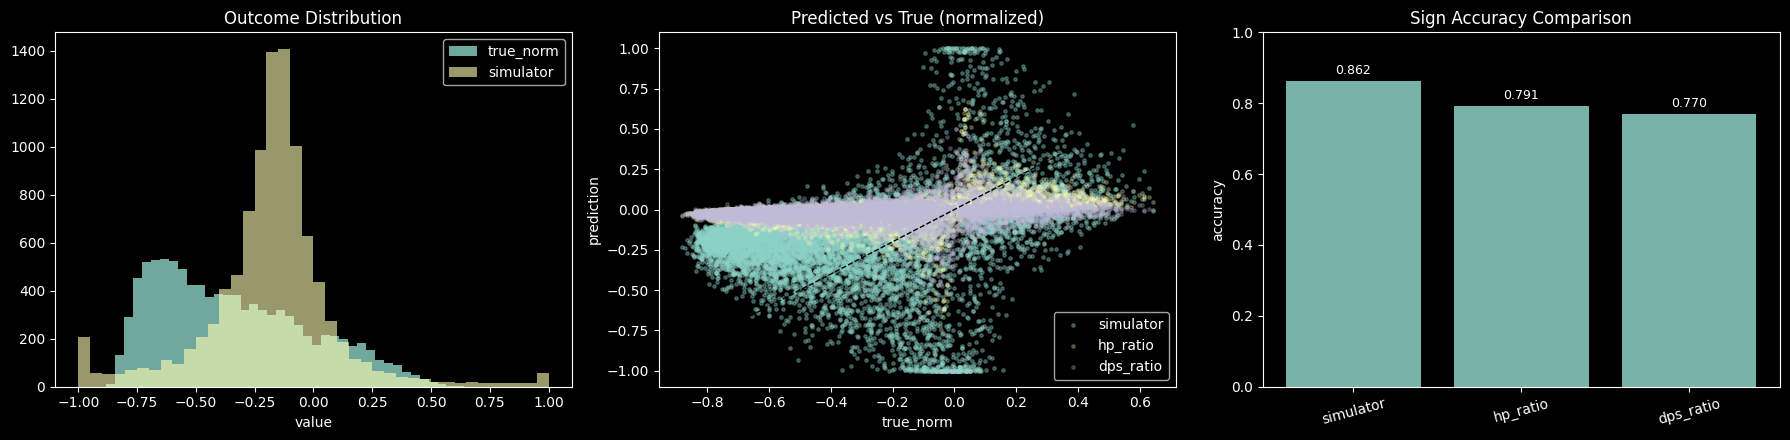

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

axes[0].hist(true_norm, bins=40, alpha=0.8, label="true_norm")
axes[0].hist(pred_sim, bins=40, alpha=0.6, label="simulator")
axes[0].set_title("Outcome Distribution")
axes[0].set_xlabel("value")
axes[0].legend()

axes[1].scatter(true_norm, pred_sim, s=6, alpha=0.35, label="simulator")
axes[1].scatter(true_norm, hp_ratio, s=6, alpha=0.25, label="hp_ratio")
axes[1].scatter(true_norm, dps_ratio, s=6, alpha=0.25, label="dps_ratio")
axes[1].axline((0, 0), slope=1.0, linestyle="--", linewidth=1, color="black")
axes[1].set_title("Predicted vs True (normalized)")
axes[1].set_xlabel("true_norm")
axes[1].set_ylabel("prediction")
axes[1].legend(loc="lower right")

models = [m["model"] for m in metrics]
acc = [m["sign_accuracy"] for m in metrics]
x = np.arange(len(models))
axes[2].bar(x, acc, alpha=0.85)
axes[2].set_xticks(x, models, rotation=15)
axes[2].set_ylim(0.0, 1.0)
axes[2].set_title("Sign Accuracy Comparison")
axes[2].set_ylabel("accuracy")
for i, v in enumerate(acc):
    axes[2].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

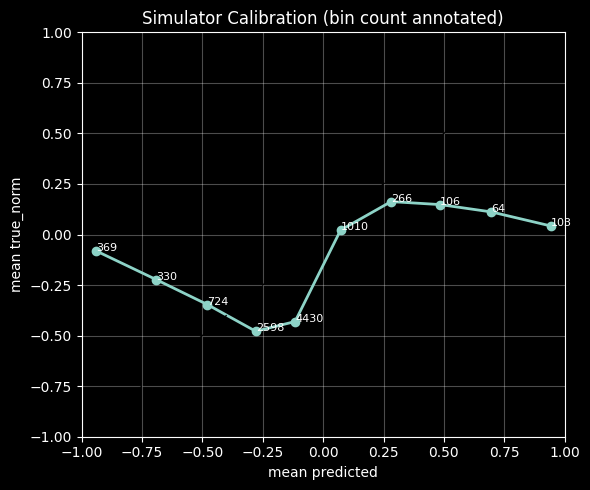

[{'bin_center': -0.9,
  'mean_pred': -0.9404538838893631,
  'mean_true': -0.08075528824836281,
  'count': 369},
 {'bin_center': -0.7,
  'mean_pred': -0.6915766192601706,
  'mean_true': -0.22274267974511225,
  'count': 330},
 {'bin_center': -0.49999999999999994,
  'mean_pred': -0.4790914088773055,
  'mean_true': -0.3464966587260788,
  'count': 724},
 {'bin_center': -0.29999999999999993,
  'mean_pred': -0.27933340035441323,
  'mean_true': -0.47839541338441605,
  'count': 2598},
 {'bin_center': -0.09999999999999998,
  'mean_pred': -0.11633303584488962,
  'mean_true': -0.43051809638328586,
  'count': 4430},
 {'bin_center': 0.10000000000000009,
  'mean_pred': 0.07219560821136616,
  'mean_true': 0.021595403736570512,
  'count': 1010},
 {'bin_center': 0.30000000000000016,
  'mean_pred': 0.2813609718782316,
  'mean_true': 0.16280488209245594,
  'count': 266},
 {'bin_center': 0.5000000000000001,
  'mean_pred': 0.48466503234470426,
  'mean_true': 0.14805636694871388,
  'count': 106},
 {'bin_cent

In [7]:
bins = np.linspace(-1.0, 1.0, 11)
digitized = np.digitize(pred_sim, bins)
calibration = []
for b in range(1, len(bins)):
    mask = digitized == b
    count = int(mask.sum())
    if count == 0:
        continue
    calibration.append({
        "bin_center": float((bins[b - 1] + bins[b]) / 2),
        "mean_pred": float(pred_sim[mask].mean()),
        "mean_true": float(true_norm[mask].mean()),
        "count": count,
    })

cal_pred = np.array([c["mean_pred"] for c in calibration])
cal_true = np.array([c["mean_true"] for c in calibration])
cal_count = np.array([c["count"] for c in calibration])

plt.figure(figsize=(6, 5))
plt.plot(cal_pred, cal_true, marker="o", linewidth=2)
plt.axline((0, 0), slope=1.0, linestyle="--", color="black", linewidth=1)
for x, y, c in zip(cal_pred, cal_true, cal_count):
    plt.text(x, y, str(int(c)), fontsize=8)
plt.title("Simulator Calibration (bin count annotated)")
plt.xlabel("mean predicted")
plt.ylabel("mean true_norm")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

calibration

### Notes
- `true_raw` from the dataset is mapped to `true_norm = tanh(true_raw / q95)` for bounded comparisons.
- `sign_accuracy` compares winner direction only (`result > 0` means `units1` wins).
- You can tune `NotebookParameters` to test alternative simulator parameter sets.